In [1]:
from river import datasets, metrics, stream, evaluate, utils
from DeepRiver.classification import PyTorch2RiverClassifier
from DeepRiver.classification.nn_builder import build_torch_mlp_classifier
import torch
from sklearn.datasets import fetch_covtype
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [28]:
n_samples = 10000
dataset = datasets.Phishing()

metric = metrics.Accuracy()

def build_fn(n_features, n_classes=1):
    net = torch.nn.Sequential(
        torch.nn.Linear(n_features, n_classes),
        torch.nn.Sigmoid()
    )
    return net

optimizer_fn = torch.optim.SGD
model = PyTorch2RiverClassifier(build_fn=build_fn,loss_fn="bce",optimizer_fn=optimizer_fn)

In [29]:
for x,y in dataset:
    y_pred = model.predict_one(x)      # make a prediction
    metric = metric.update(y, y_pred)  # update the metric
    model = model.learn_one(x, y)    # make the model learn
metric

Accuracy: 68.64%

In [30]:
track = evaluate.Track('Pishing', dataset, metrics.Accuracy(), n_samples=n_samples)
model = PyTorch2RiverClassifier(build_fn=build_fn,loss_fn="bce",optimizer_fn=optimizer_fn)

step = []
error = []
r_time = []
memory = []

for checkpoint in tqdm(track.run(model, n_checkpoints=100)):
    step.append(checkpoint["Step"])
    error.append(checkpoint['Accuracy'])
    r_time.append(checkpoint["Time"].total_seconds())
    raw_memory, unit = float(checkpoint["Memory"][:-3]), checkpoint["Memory"][-2:]
    memory.append(raw_memory * 2**-10 if unit == 'KB' else raw_memory)
print(f'Accuracy: %.2f%%' % (error[-1]*100))

12it [00:00, 25.37it/s]

Accuracy: 68.64%


Text(0.5, 0, 'Instances')

<Figure size 432x288 with 0 Axes>

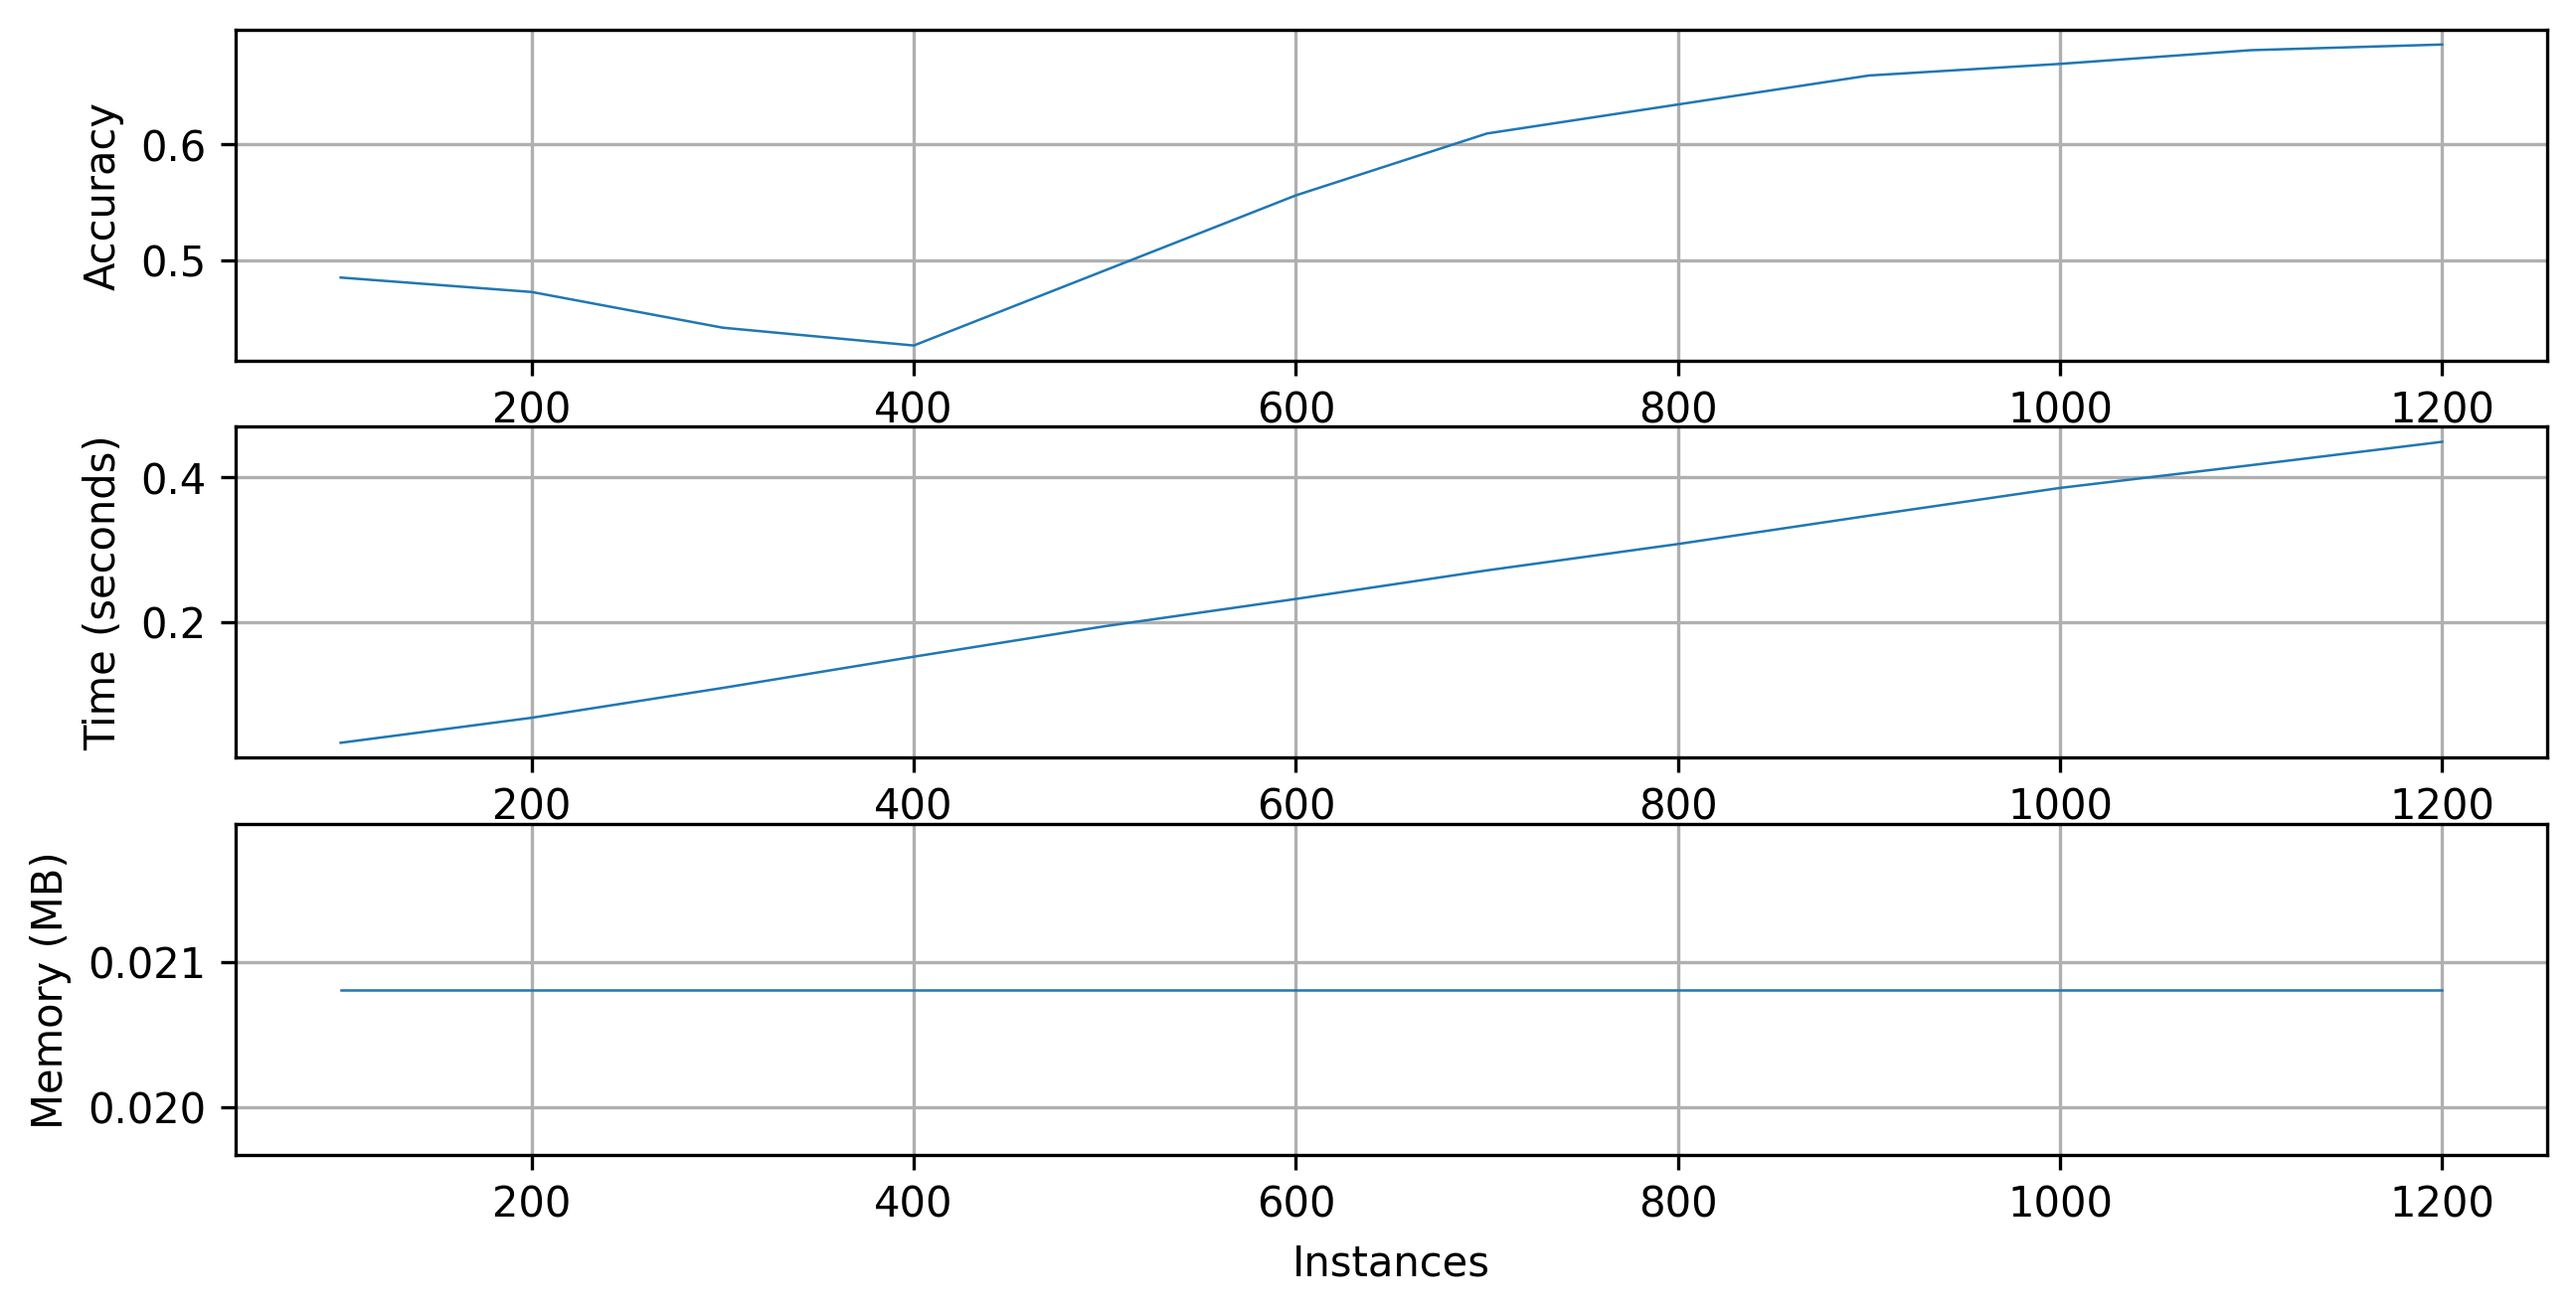

In [31]:

plt.clf()
fig, ax = plt.subplots(figsize=(10, 5), nrows=3, dpi=300 )
ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)

ax[0].plot(step, error, label=type(model).__name__,linewidth=.6)
ax[0].set_ylabel('Accuracy')

ax[1].plot(step, r_time, label=type(model).__name__,linewidth=.6)
ax[1].set_ylabel('Time (seconds)')

ax[2].plot(step, memory, label=type(model).__name__,linewidth=.6)
ax[2].set_ylabel('Memory (MB)')
ax[2].set_xlabel('Instances')
